In [1]:
#impoting the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

# Data Understanding

Setting up the path to data

In [3]:
from pathlib import Path

image_path = Path("./plants-dataset") 
train_dir = image_path / 'train'
valid_dir = image_path / 'valid'
test_dir = Path("./plants-dataset/test")

In [4]:
train_data = datasets.ImageFolder(root=train_dir,transform=transforms.ToTensor())
valid_data = datasets.ImageFolder(root=valid_dir,transform=transforms.ToTensor())

In [5]:
class_names = train_data.classes
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [6]:
print(f"It has {len(train_data.classes)} classes")

It has 38 classes


In [7]:
print(f"Number of images in train data: {len(train_data)}")
print(f"Number of images in valid data: {len(valid_data)}")

Number of images in train data: 70295
Number of images in valid data: 17572


### Checking for class imbalances

In [8]:
import os
len(os.listdir(train_dir))

38

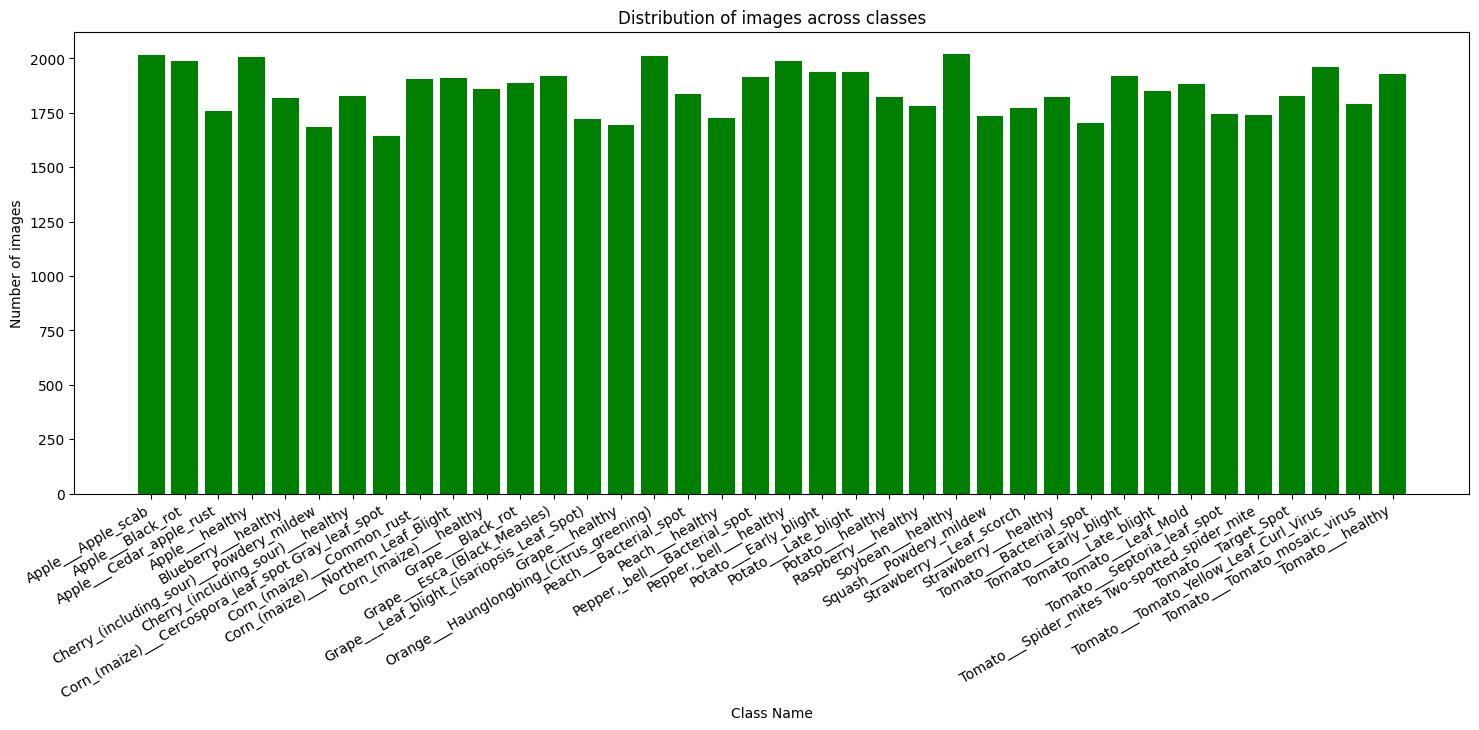

In [9]:
import os

class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir,class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(18,6))
plt.bar(classes,counts,color='green')
plt.xlabel('Class Name')
plt.ylabel('Number of images')
plt.title("Distribution of images across classes")
plt.xticks(rotation=30,ha='right')
plt.show()

**Conclusion**: The number of images across all the classes are fairly similar and there are no class imbalances

Image Class: Tomato___Late_blight
Image height: 256
Image width: 256


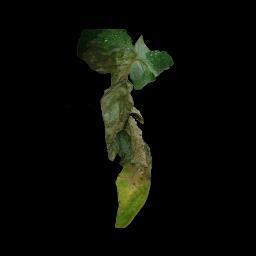

In [10]:
import random
from PIL import Image
random.seed(40)
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

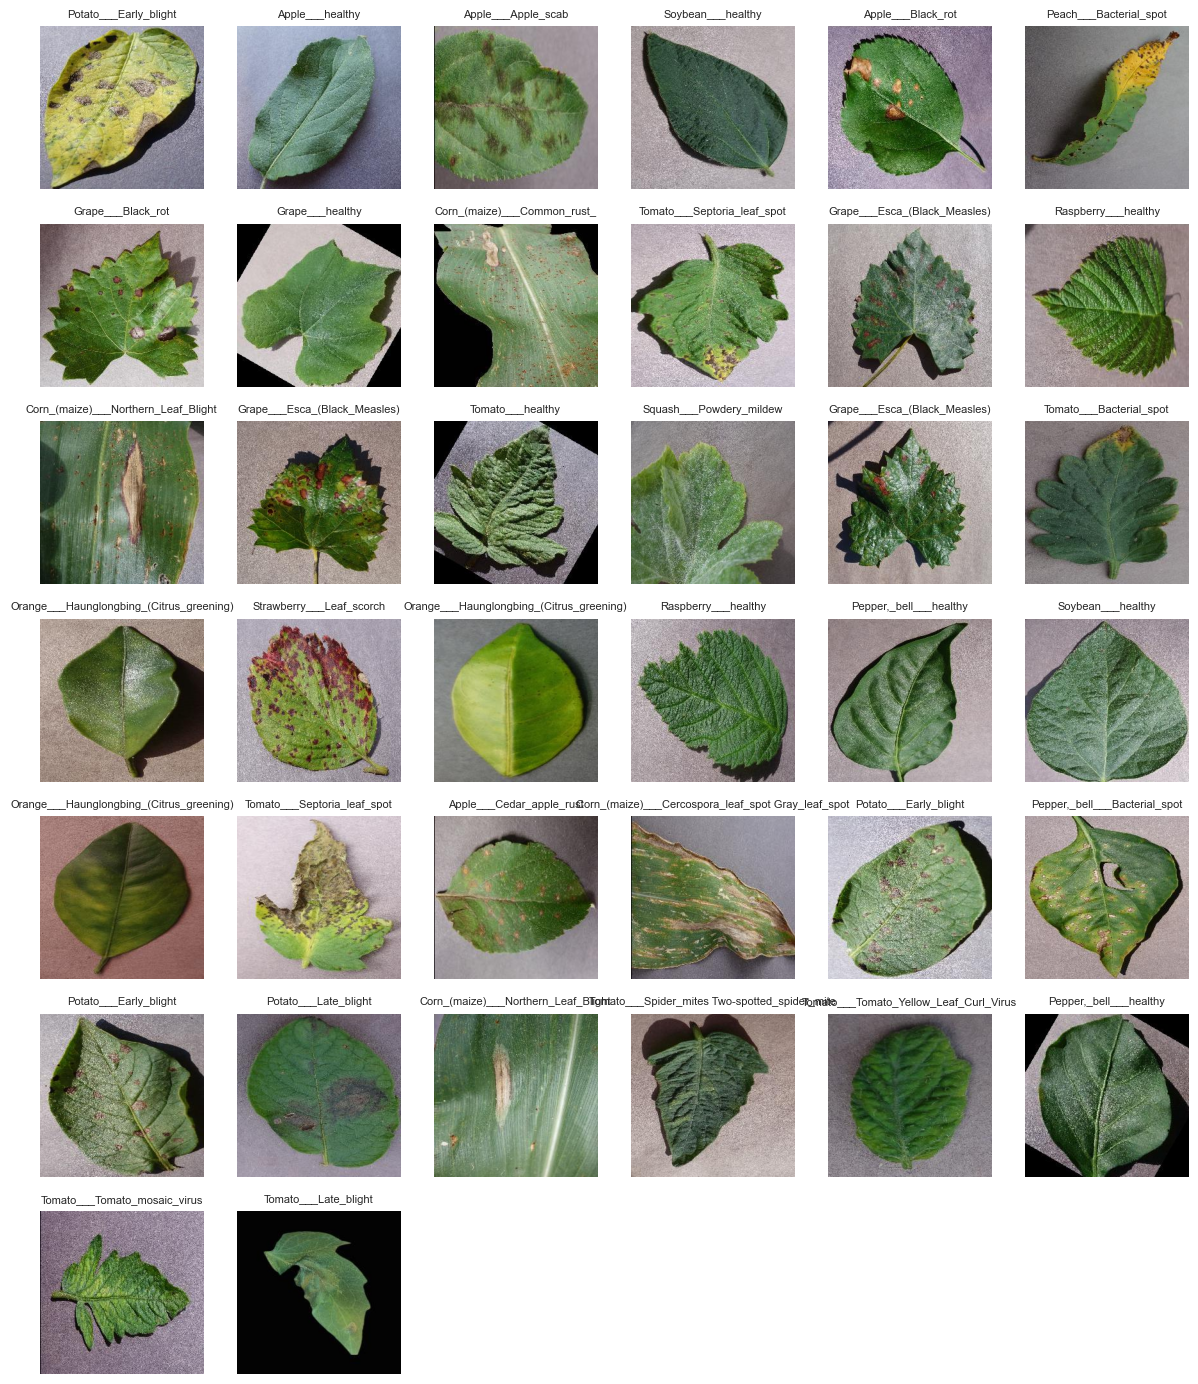

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import seaborn as sns

def visualize_dataset_images(dataset, num_images=38):
    sns.set(style="whitegrid")

    # Dynamically calculate grid dimensions
    num_cols = 6  #adjust this for a different aspect ratio
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division

    # Adjust figure size
    figsize = (num_cols * 2, num_rows * 2)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Load images and labels
    dataloader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(dataloader))

    axs = axs.flatten()  # Flatten axes array for easier indexing
    for idx, img in enumerate(images):
        if idx >= num_images:
            break
        axs[idx].imshow(np.clip(img.numpy().transpose(1, 2, 0), 0, 1))
        axs[idx].axis('off')
        axs[idx].set_title(f"{dataset.classes[labels[idx]]}", fontsize=8)

    # Remove unused axes
    for idx in range(len(images), len(axs)):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.show()


visualize_dataset_images(train_data)

### Transformations
1) Resizing all the image to 256 x 256 for consistent dimensions
2) Random Horizontal/Vertivcal Flips to make it robust to orientation changes
3) Color Jitter for making it robust against lighting conditions
4) Normalization for better data integrity

In [12]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
])

## Creating Dataloaders

In [13]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,transform = transforms)
test_data = datasets.ImageFolder(root=valid_dir,transform = transforms)

In [14]:
import os
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data,
                            batch_size = BATCH_SIZE,
                            shuffle=False,
                            num_workers = NUM_WORKERS)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cff560b85f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7cff536f1fa0>)

## Device agnostics

In [15]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
# creating trian_test loops
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [17]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [18]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

/home/sujal/Desktop/Tech/Data Science/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
class PlantDiseaseNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size =3,padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 32,out_channels =64 , kernel_size = 3,padding =1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding =1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels = 128,out_channels=256,kernel_size = 3,padding = 1 ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 8*8*256,out_features = 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=1024,out_features = len(class_names))
        )
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.classifier(x)
        return x

In [20]:
model = PlantDiseaseNN().to(device)

In [21]:
from torchinfo import summary
summary(model,input_size=[1,3,256,256])

Layer (type:depth-idx)                   Output Shape              Param #
PlantDiseaseNN                           [1, 38]                   --
├─Sequential: 1-1                        [1, 32, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 32, 256, 256]         896
│    └─BatchNorm2d: 2-2                  [1, 32, 256, 256]         64
│    └─ReLU: 2-3                         [1, 32, 256, 256]         --
│    └─MaxPool2d: 2-4                    [1, 32, 128, 128]         --
├─Sequential: 1-2                        [1, 64, 64, 64]           --
│    └─Conv2d: 2-5                       [1, 64, 128, 128]         18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 128, 128]         128
│    └─ReLU: 2-7                         [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-8                    [1, 64, 64, 64]           --
├─Sequential: 1-3                        [1, 128, 32, 32]          --
│    └─Conv2d: 2-9                       [1, 128, 64, 64]          73,856
│    

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),lr=0.0001,weight_decay=0.01)

In [ ]:
from timeit import default_timer as timer 
start_time = timer()
model_results = train(model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader,optimizer=optimizer,loss_fn=loss_fn,epochs=15,)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
import shutil


torch.save(model.state_dict(), 'model.pth')


shutil.move('model.pth', '/kaggle/working/model.pth')

In [ ]:
saved_model = PlantDiseaseNN().to(device)  
saved_model.load_state_dict(torch.load('/kaggle/working/model.pth',weights_only=True))
saved_model.eval()

## Evaluation of model

In [ ]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_curves(model_results)

No signs of overfitting.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch

def evaluate(model: torch.nn.Module, 
             dataloader: torch.utils.data.DataLoader, 
             loss_fn: torch.nn.Module,
             device: torch.device):
    # To store predictions and true labels for calculating the metrics
    all_preds = []
    all_labels = []
    
    # Variable to accumulate total correct predictions for accuracy
    correct_preds = 0
    total_preds = 0

    # Evaluate the model using the existing test_step function and collect predictions
    model.eval()  # Switch model to evaluation mode
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            # Move data to the device
            X, y = X.to(device), y.to(device)

            # Get model predictions using test_step
            test_pred_logits = model(X)

            # Get predicted class labels
            test_pred_labels = test_pred_logits.argmax(dim=1)
            
            # Store predictions and true labels
            all_preds.extend(test_pred_labels.cpu().numpy())  # move to CPU for metrics calculation
            all_labels.extend(y.cpu().numpy())
            
            # Calculate correct predictions for accuracy
            correct_preds += (test_pred_labels == y).sum().item()
            total_preds += len(y)

    # Calculate accuracy
    accuracy = correct_preds / total_preds

    # Calculate the precision, recall, and f1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, cm

In [ ]:
accuracy, precision, recall, f1, cm = evaluate(saved_model, test_dataloader, loss_fn, device)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [ ]:
plt.figure(figsize=(20,20))
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
sns.heatmap(cm,annot=True)
plt.show()

## Evaluation on actual test set.


In [ ]:
image_size = (256, 256)  
preprocess = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)]) 

# Load and preprocess images
test_folder = '/kaggle/input/new-plant-diseases-dataset/test/test' 
image_names = os.listdir(test_folder)  

# Plot predictions for all images
num_images = len(image_names)  # Total number of images
num_cols = 5  # Number of columns in the plot grid
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows needed

plt.figure(figsize=(25, 5 * num_rows))  # Adjust figure size dynamically
for i, img_name in enumerate(image_names):
    img_path = os.path.join(test_folder, img_name)
    img = Image.open(img_path).convert('RGB')  # Ensure 3 channels
    img_tensor = preprocess(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

   
    with torch.no_grad():
        predictions = saved_model(img_tensor)
    predicted_class_idx = torch.argmax(predictions, dim=1).item()  # Get predicted class index
    predicted_label = class_names[predicted_class_idx]  # Map to class name

    actual_class = img_name
    # Plot the image with the actual and predicted labels
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class_names[7],class_names[9]

In [ ]:
class_names[0],class_names[1]

### The model gets confused between these the most:
1) **Corn(maize)_cercospora_leaf_spot Gray_leaf_sopt** and **Corn(maize)_Northern_Leaf_Blight**
2) **Apple___Apple_scab** and **Apple___Black_rot**